<a href="https://colab.research.google.com/github/pvgandhi404/Fake-News-Detection/blob/main/NLP_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [10]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model, save_model

!pip install datasets
from datasets import load_dataset

import nltk
from nltk.corpus import stopwords

# Process training and testing data from Hugginface

In [11]:
# Dataset being used: https://huggingface.co/datasets/GonzaloA/fake_news
dataset = load_dataset("GonzaloA/fake_news")

training_data = list(dataset['train'])
test_data = list(dataset['test'])

# Organize into arrays of content and boolean labels

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  word_list = text.split()

  filtered_list = [word for word in word_list if word not in stop_words]
  return ' '.join(filtered_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

for news in training_data:
  content = news["title"] + " " + news["text"]
  content = remove_stopwords(content)

  train_sentences.append(content)
  train_labels.append(news["label"])

for news in test_data:
  content = news["title"] + " " + news["text"]

  test_sentences.append(content)
  test_labels.append(news["label"])

In [14]:
## convert lists into numpy array
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [15]:
# for i in range (0, 10):
#   print(test_labels[i], ": ", test_sentences[i])

# Tokenize and pad

In [16]:
vocab_size = 10000
seq_length = 100
oov_token = "<UNK>"
trunc_type = "post"
embedding_dim = 64
lstm_units = 32

In [17]:
## Tokenize
tokenizer = Tokenizer(num_words=vocab_size, lower= True, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

## Training data
train_seqs = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seqs, maxlen=seq_length, truncating=trunc_type)

## Testing data
test_seqs = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seqs,maxlen=seq_length)

In [18]:
# print(train_seqs[13])
# print(train_padded[13])

# Neural Network

In [19]:

# Build the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=seq_length))

model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=embedding_dim,
                                    input_length=seq_length))

model.add(tf.keras.layers.LSTM(units=lstm_units))

model.add(tf.keras.layers.Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           7972608   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7987201 (30.47 MB)
Trainable params: 7987201 (30.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
num_epochs = 15
# 10 = 88.55%
# 15 = 89.34%

##train the model with training and validation set
history = model.fit(
    train_padded,   #training sequence
    train_labels, # training labels
    epochs=num_epochs,
    validation_data=(test_padded, test_labels) # test data
  )

Epoch 1/15
762/762 [==============================] - 155s 199ms/step - loss: 0.1711 - accuracy: 0.9460 - val_loss: 1.6499 - val_accuracy: 0.5825
Epoch 2/15
762/762 [==============================] - 155s 203ms/step - loss: 0.0692 - accuracy: 0.9817 - val_loss: 3.1626 - val_accuracy: 0.5758
Epoch 3/15
762/762 [==============================] - 135s 177ms/step - loss: 0.0591 - accuracy: 0.9848 - val_loss: 1.7243 - val_accuracy: 0.5741
Epoch 4/15
762/762 [==============================] - 136s 179ms/step - loss: 0.0435 - accuracy: 0.9896 - val_loss: 3.1015 - val_accuracy: 0.6137
Epoch 5/15
762/762 [==============================] - 134s 175ms/step - loss: 0.0246 - accuracy: 0.9944 - val_loss: 3.7035 - val_accuracy: 0.5545
Epoch 6/15
762/762 [==============================] - 134s 176ms/step - loss: 0.0160 - accuracy: 0.9961 - val_loss: 3.3769 - val_accuracy: 0.5604
Epoch 7/15
762/762 [==============================] - 142s 186ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 4.1480 -

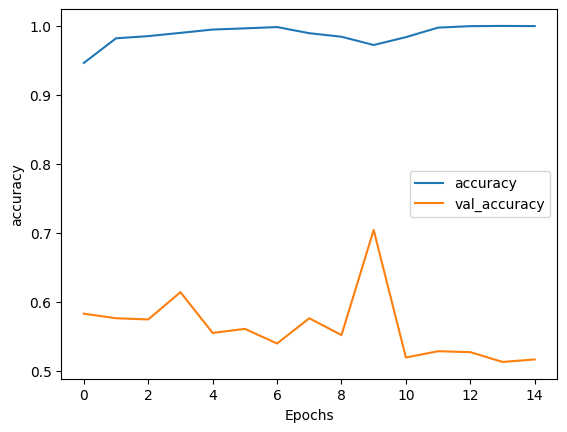

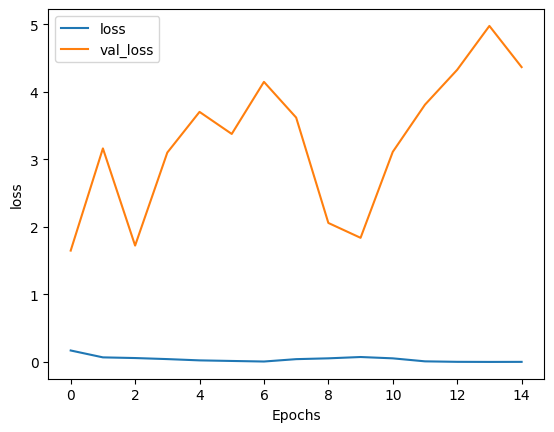

In [21]:
import matplotlib.pyplot as plt

##plot the scores from history
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric])
  plt.legend([metric, 'val_'+ metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()

##plot accuracy
plot_metrics(history, "accuracy")

##plot loss
plot_metrics(history, "loss")

In [22]:
model.save("fake_news_predict.h5")

model = load_model("fake_news_predict.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
sentence = ["In an powerful moment for a night that is usually designated to honoring celebrities and movies, Vice President Joe Biden took to the stage at the 88th Annual Academy Awards to deliver a message about sexual assault.Biden recently took a break from organizing a national initiative to cure cancer to help launch a program that asks young people to fight against sexual assault by standing up and intervening if they see a situation where consent cannot or has not been given. Taking the microphone at the Academy Awards ceremony, Biden was greeted with a standing ovation from the attendees. The applause was so intense, in fact, that Biden had to settle people down with a joke, telling the collected group of megastars, I m the least qualified man here tonight. Joe Biden introduces Lady Gaga at the #Oscars. https://t.co/aRmjqBSbjg MTV News (@MTVNews) February 29, 2016During his brief remarks, Biden made it clear that victim-blaming had no place in our society. Let s change the culture so that no abused woman or man ever feels they have to ask themselves What did I do? They did nothing wrong. The vice president was joined by Lady Gaga, who helped make a documentary on the subject of date-rape on college campuses. The two promoted a website called ItsOnUs.org that will help spread the message of what people can do to help stop sexual assaults in universities around the country. Afterwards, Lady Gaga performed a song she had written for the documentary. At the conclusion, she was joined by survivors of sexual assault. The performance brought the house down and reduced many in the audience to tears.Powerful. https://t.co/vG5LjQdCo9 #Oscars https://t.co/SSzZEcxSLX ABC News (@ABC) February 29, 2016After the performance, Biden tweeted a photo of himself and Lady Gaga.Proud to stand by my friend @LadyGaga tonight. Pure courage that inspires, challenges us all. #ItsOnUs. All of us. pic.twitter.com/1eee3v0Xd2 Vice President Biden (@VP) February 29, 2016And to those cynics who might believe a speech during the Oscars won t accomplish anything, consider this: From the instant it was mentioned, the ItsOnUs.org website was brought to a crawl under the weight of the traffic. That s a lot of eyes on an issue that is far too often swept under the rug and ignored.Featured image via ABC News/Twitter"]
sentence = remove_stopwords(sentence)

##prepare the sequences of the sentences in question
sequences = tokenizer.texts_to_sequences(sentence)
padded_seqs = pad_sequences(sequences=sequences, maxlen=seq_length, truncating=trunc_type)

##print the classification score
print(model.predict(padded_seqs))

1/1 [==============================] - 1s 756ms/step
[[2.5823724e-06]]
